<a href="https://colab.research.google.com/github/ardhiapp26/tutor/blob/main/Landmarks_Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landmark Image Retrieval


# Deep Local and Global Image Features
![](https://www.i-programmer.info/images/stories/News/2018/march/A/delfpipeline.JPG)

# Import Library


In [1]:
!pip install -q scikit-image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from absl import logging

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO

import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

# Load data


In [2]:
IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/28/Bridge_of_Sighs%2C_Oxford.jpg'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/c3/The_Bridge_of_Sighs_and_Sheldonian_Theatre%2C_Oxford.jpg'

In [3]:
def download_and_resize(name, url, new_width=256, new_height=256):
  path = tf.keras.utils.get_file(url.split('/')[-1], url)
  image = Image.open(path)
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
  return image

14164194/14164194 [==============================] - 1s 0us/step


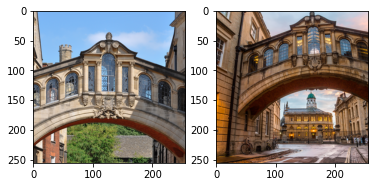

In [4]:
image1 = download_and_resize('image_1.jpg', IMAGE_1_URL)
image2 = download_and_resize('image_2.jpg', IMAGE_2_URL)

plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

In [5]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

# Processing

In [6]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

In [7]:
result1 = run_delf(image1)
result2 = run_delf(image2)

In [8]:
def match_images(image1, image2, result1, result2):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  
  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)
  
  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
    # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots(figsize=(20, 20))
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

Loaded image 1's 233 features
Loaded image 2's 262 features
Found 48 inliers


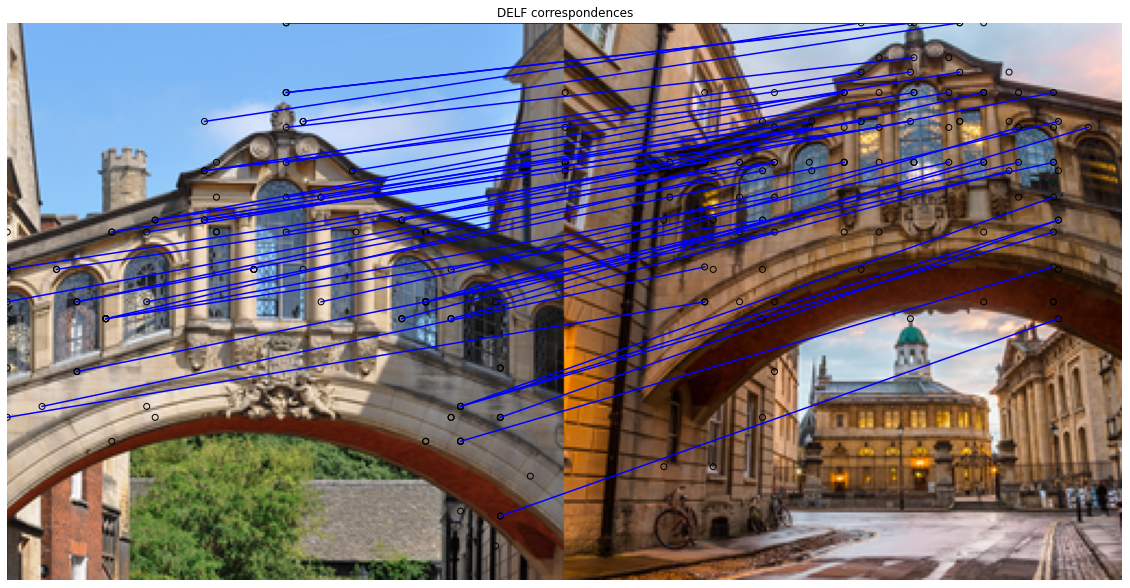

In [9]:
match_images(image1, image2, result1, result2)